### Stock Trading Strategy using Classification Algorithms to Predict Market Movements and Backtesting

In [1]:
# make the necessary imports 
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import yfinance as yf
import warnings
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import datetime
import pyfolio as pf
import backtrader as bt
from backtrader.feeds import PandasData
import warnings

# set the style and ignore warnings
plt.style.use('seaborn-colorblind')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

d:\code\python\pyfolio\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [2]:
# this is to display images in notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Data Gathering

In [3]:
# ticker and the start and end dates for testing
# ticker = '^NSEI' # Nifty 50 benchmark
# start = datetime.datetime(2010, 1, 1)
# end = datetime.datetime(2020, 7, 31)

start = '2021-01-01'
end = '2021-12-12'

In [4]:
# download ticker ‘Adj Close’ price from yahoo finance
# stock =  yf.download(ticker, progress=True, actions=True,start=start, end=end)['Adj Close']
# stock = pd.DataFrame(stock)
# stock.rename(columns = {'Adj Close':ticker}, inplace=True)
# stock.head(2)

In [5]:
from lutils.stock import LTdxHq

In [6]:
ltdxhq = LTdxHq()

In [7]:
code = '600519' # 000032 300142 603636 600519
ticker = code

df = ltdxhq.get_k_data_daily(code, start=start, end=end)
df.index = pd.to_datetime(df.index)

prices = df
stock = pd.DataFrame(df.close)

stock.rename(columns = {'close': ticker}, inplace=True)
stock.head(2)

,600519
date,
2021-01-04,1978.37
2021-01-05,2040.24


In [8]:
# calculate daily log returns and market direction
stock['returns'] = np.log(stock / stock.shift(1))
stock.dropna(inplace=True)
stock['direction'] = np.sign(stock['returns']).astype(int)
stock.head(3)

,600519,returns,direction
date,,,
2021-01-05,2040.24,0.030794,1
2021-01-06,2080.41,0.019498,1
2021-01-07,2120.04,0.018870,1


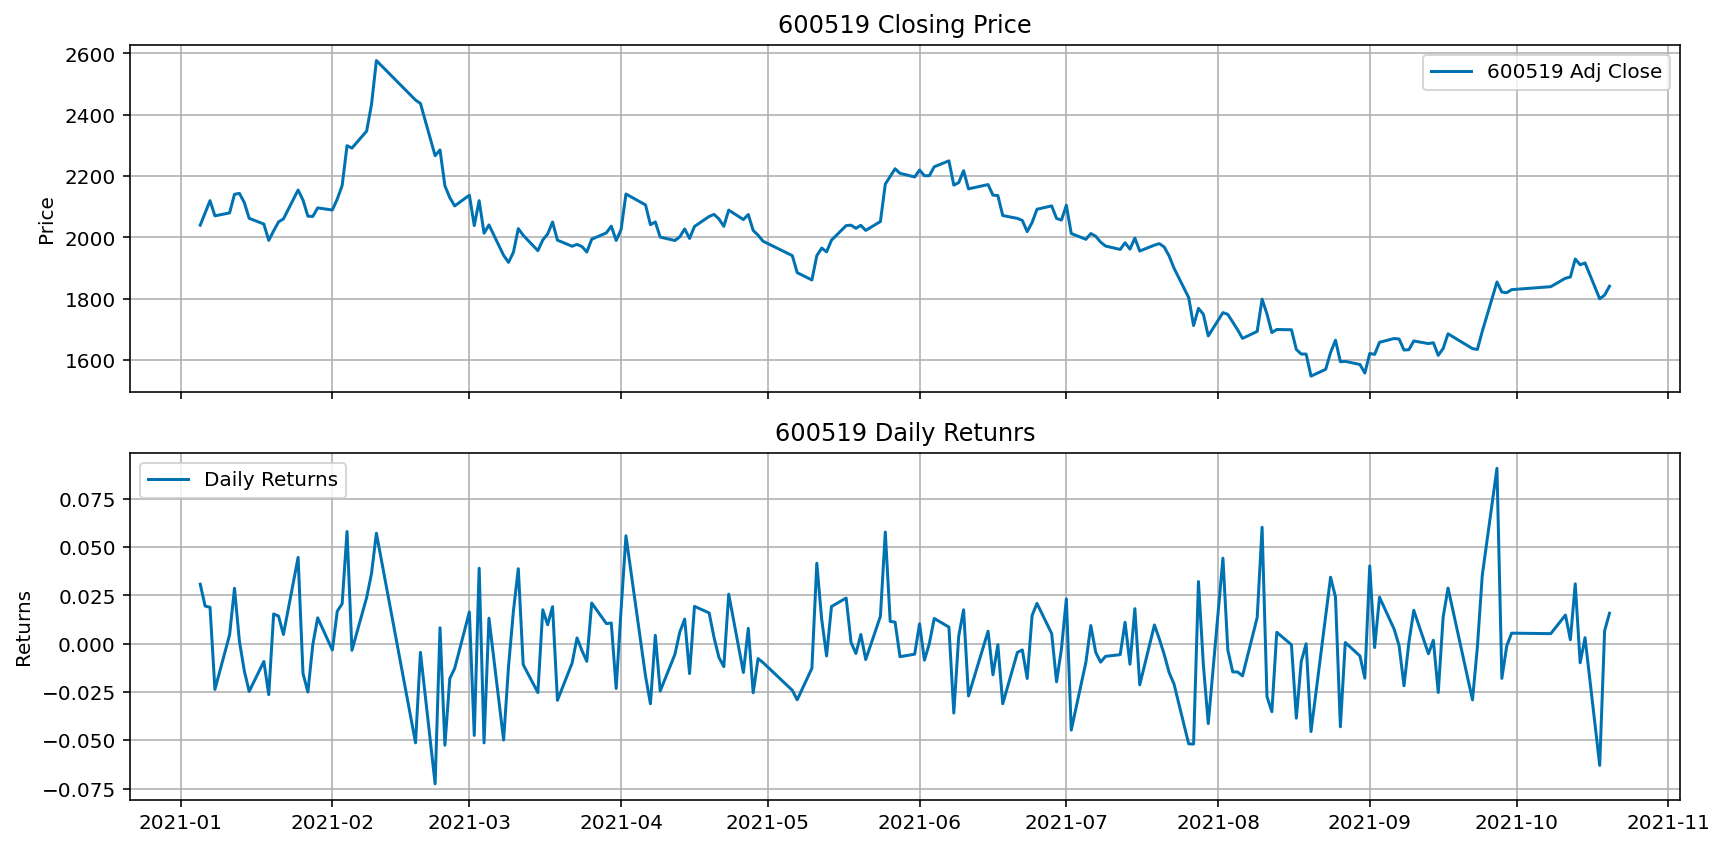

In [9]:
# visualize the closing price and daily returns
fig, ax = plt.subplots(2, 1, sharex=True, figsize = (12,6))
ax[0].plot(stock[ticker], label = f'{ticker} Adj Close')
ax[0].set(title = f'{ticker} Closing Price', ylabel = 'Price')
ax[0].grid(True)
ax[0].legend()

ax[1].plot(stock['returns'], label = 'Daily Returns')
ax[1].set(title = f'{ticker} Daily Retunrs', ylabel = 'Returns')
ax[1].grid(True)
plt.legend()

plt.tight_layout();
# plt.savefig('images/chart1', dpi=300)
plt.show()

### Feature Engineering

In [10]:
# define the number of lags
lags = [1, 2, 3, 4, 5]

In [11]:
# compute lagged log returns
cols = []
for lag in lags:
    col = f'rtn_lag{lag}'
    stock[col] = stock['returns'].shift(lag)
    cols.append(col)

stock.dropna(inplace=True)
stock.head(2)

,600519,returns,direction,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5
date,,,,,,,,
2021-01-12,2140.74,0.028716,1,0.004645,-0.023645,0.018870,0.019498,0.030794
2021-01-13,2143.81,0.001433,1,0.028716,0.004645,-0.023645,0.018870,0.019498


In [12]:
# cols

In [13]:
# function to transform the lag returns to binary values (0,+1)
def create_bins(data, bins=[0]):
    global cols_bin
    cols_bin = []
    for col in cols:
        col_bin = col + '_bin'
        data[col_bin] = np.digitize(data[col], bins=bins)  
        cols_bin.append(col_bin)

In [14]:
create_bins(stock)
stock[cols+cols_bin].head(2)

,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5,rtn_lag1_bin,rtn_lag2_bin,rtn_lag3_bin,rtn_lag4_bin,rtn_lag5_bin
date,,,,,,,,,,
2021-01-12,0.004645,-0.023645,0.018870,0.019498,0.030794,1,0,1,1,1
2021-01-13,0.028716,0.004645,-0.023645,0.018870,0.019498,1,1,0,1,1


In [15]:
# cols_bin

### Build and Apply Classification Machine Learning Algorithms

Select Logistic regression, Gaussian Naive Bayes, Support Vector Machine, Random Forest, and MLP Classifier approaches to predict the market direction. Please refer sklearn documentation for detail on these and other algorithms.
https://scikit-learn.org/stable/index.html

In [16]:
# create a dictionary of selected algorithms
models = {
    'log_reg': linear_model.LogisticRegression(),
    'gauss_nb': GaussianNB(),
    'svm': SVC(),
    'random_forest': RandomForestClassifier(max_depth=15, n_estimators=200),
    'MLP' : MLPClassifier(max_iter=500),
}

In [17]:
# function that fits all models.
def fit_models(data):  
    mfit = {model: models[model].fit(data[cols_bin], data['direction']) for model in models.keys()} 

In [18]:
# function that predicts (derives all position values) from the fitted models
def derive_positions(data):  
    for model in models.keys():
        data['pos_' + model] = models[model].predict(data[cols_bin])

In [19]:
# function to evaluate all trading strategies
def evaluate_strats(data):  
    global strategy_rtn
    strategy_rtn = []
    for model in models.keys():
        col = 'strategy_' + model 
        data[col] = data['pos_' + model] * data['returns']
        strategy_rtn.append(col)
    strategy_rtn.insert(0, 'returns')

In [20]:
# fit the models
fit_models(stock)

In [21]:
# derives all position values
derive_positions(stock)

In [22]:
# evaluate all trading strategies by multiplying predicted directions to actual daily returns
evaluate_strats(stock)

In [23]:
# calculate total return and std. deviation of each strategy
print('\nTotal Returns:')
print(stock[strategy_rtn].sum().apply(np.exp))
print('\nAnnual Volatility:')
stock[strategy_rtn].std() * 252 ** 0.5


Total Returns:
returns                   0.885037
strategy_log_reg          1.629947
strategy_gauss_nb         1.566230
strategy_svm              2.652746
strategy_random_forest    2.631033
strategy_MLP              2.671210
dtype: float64

Annual Volatility:


returns                   0.394869
strategy_log_reg          0.392766
strategy_gauss_nb         0.393118
strategy_svm              0.385987
strategy_random_forest    0.386140
strategy_MLP              0.385856
dtype: float64

In [24]:
# number of trades over time for highest and second highest return strategy
print('Number of trades SVM = ', (stock['pos_svm'].diff()!=0).sum())
print('Number of trades Ramdom Forest = ',(stock['pos_random_forest'].diff()!=0).sum())

Number of trades SVM =  95
Number of trades Ramdom Forest =  91


In [25]:
# stock[[ticker]+ strategy_rtn].head(2)

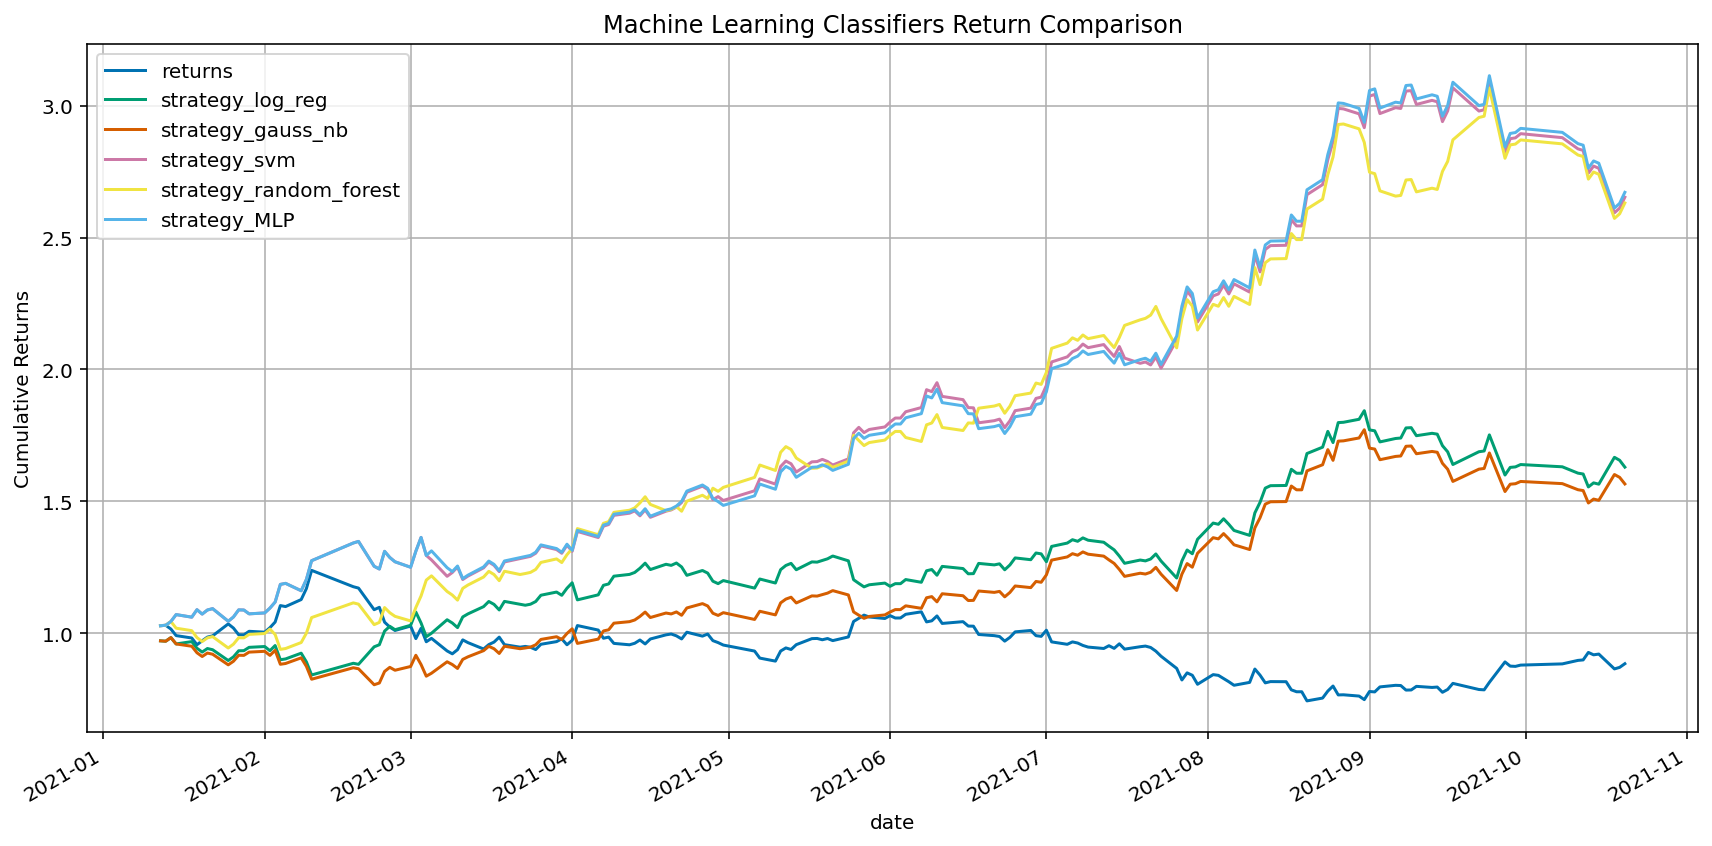

In [26]:
# vectorized backtesting of the resulting trading strategies and visualize the performance over time
ax = stock[strategy_rtn].cumsum().apply(np.exp).plot(figsize=(12, 6), 
                                                     title = 'Machine Learning Classifiers Return Comparison')
ax.set_ylabel("Cumulative Returns")
ax.grid(True);
plt.tight_layout();
# plt.savefig('images/chart2', dpi=300)
plt.show()

### Backtesting of Selected Strategy using Backtrader

In [27]:
# fetch the daily pricing data from yahoo finance
# prices =  yf.download(ticker, progress=True, actions=True, start=start, end=end)
# prices.head(2)

In [28]:
# rename the columns as needed for Backtrader
# prices.drop(['Close','Dividends','Stock Splits'], inplace=True, axis=1)
# prices.rename(columns = {'Open':'open','High':'high','Low':'low','Adj Close':'close','Volume':'volume',
#                          }, inplace=True)

In [29]:
prices.head(3)

,open,close,high,low,volume,amount
date,,,,,,
2021-01-04,1981.32,1978.37,1986.29,1965.30,4351400.0,8.686921e+09
2021-01-05,1971.44,2040.24,2040.24,1963.97,5211605.0,1.059256e+10
2021-01-06,2045.54,2080.41,2105.18,2017.04,4741020.0,9.882594e+09


In [30]:
# add the predicted column to prices dataframe. This will be used as signal for buy or sell
predictions = stock['strategy_svm']
predictions = pd.DataFrame(predictions)
predictions.rename(columns = {'strategy_svm':'predicted'}, inplace=True)
prices = predictions.join(prices, how='right').dropna()
prices.head(2)

,predicted,open,close,high,low,volume,amount
date,,,,,,,
2021-01-12,0.028716,2068.52,2140.74,2140.74,2065.55,4105859.0,8.800558e+09
2021-01-13,0.001433,2143.81,2143.81,2153.05,2115.08,3438993.0,7.418331e+09


In [31]:
# prices[['predicted']].sum().apply(np.exp)

In [32]:
OHLCV = ['open', 'high', 'low', 'close', 'volume']

In [33]:
# class to define the columns we will provide
class SignalData(PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = OHLCV + ['predicted']

    # create lines
    lines = tuple(cols)

    # define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

Strategy: 
1.	Buy when the predicted value is +1 and sell (only if stock is in possession) when the predicted value is -1.
2.	All-in strategy—when creating a buy order, buy as many shares as possible.
3.	Short selling is not allowed

In [34]:
# define backtesting strategy class
class MLStrategy(bt.Strategy):
    params = dict(
    )
    
    def __init__(self):
        # keep track of open, close prices and predicted value in the series
        self.data_predicted = self.datas[0].predicted
        self.data_open = self.datas[0].open
        self.data_close = self.datas[0].close
        
        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None

    # logging function
    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )

        # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log('Order Failed')

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')

    # We have set cheat_on_open = True.This means that we calculated the signals on day t's close price, 
    # but calculated the number of shares we wanted to buy based on day t+1's open price.
    def next_open(self):
        if not self.position:
            if self.data_predicted > 0:
                # calculate the max number of shares ('all-in')
                size = int(self.broker.getcash() / self.datas[0].open)
                # buy order
                self.log(f'BUY CREATED --- Size: {size}, Cash: {self.broker.getcash():.2f}, Open: {self.data_open[0]}, Close: {self.data_close[0]}')
                self.buy(size=size)
        else:
            if self.data_predicted < 0:
                # sell order
                self.log(f'SELL CREATED --- Size: {self.position.size}')
                self.sell(size=self.position.size)

In [35]:
# instantiate SignalData class
data = SignalData(dataname=prices)

In [36]:
# instantiate Cerebro, add strategy, data, initial cash, commission and pyfolio for performance analysis
cerebro = bt.Cerebro(stdstats = False, cheat_on_open=True)
cerebro.addstrategy(MLStrategy)
cerebro.adddata(data, name=ticker)
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

In [37]:
# run the backtest
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
backtest_result = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2021-01-13, BUY CREATED --- Size: 46, Cash: 100000.00, Open: 2143.81, Close: 2143.81
2021-01-13, BUY EXECUTED --- Price: 2143.81, Cost: 98615.26,Commission: 98.62
2021-01-18, SELL CREATED --- Size: 46
2021-01-18, SELL EXECUTED --- Price: 2041.83, Cost: 98615.26,Commission: 93.92
2021-01-18, OPERATION RESULT --- Gross: -4691.08, Net: -4883.62
2021-01-19, BUY CREATED --- Size: 46, Cash: 95116.38, Open: 2053.77, Close: 1990.66
2021-01-19, BUY EXECUTED --- Price: 2053.77, Cost: 94473.42,Commission: 94.47
2021-01-20, SELL CREATED --- Size: 46
2021-01-20, SELL EXECUTED --- Price: 1989.27, Cost: 94473.42,Commission: 91.51
2021-01-20, OPERATION RESULT --- Gross: -2967.00, Net: -3152.98
2021-01-21, BUY CREATED --- Size: 45, Cash: 91963.40, Open: 2028.89, Close: 2050.69
2021-01-21, BUY EXECUTED --- Price: 2028.89, Cost: 91300.05,Commission: 91.30
2021-01-25, SELL CREATED --- Size: 45
2021-01-25, SELL EXECUTED --- Price: 2063.57, Cost: 91300.05,Commission: 92.8

In [38]:
# Extract inputs for pyfolio
strat = backtest_result[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
returns.name = 'Strategy'
returns.head(2)

index
2021-01-12 00:00:00+00:00    0.000000
2021-01-13 00:00:00+00:00   -0.000986
Name: Strategy, dtype: float64

In [39]:
# get benchmark returns
benchmark_rets= stock['returns']
benchmark_rets.index = benchmark_rets.index.tz_localize('UTC') 
benchmark_rets = benchmark_rets.filter(returns.index)
benchmark_rets.name = 'Nifty-50'
benchmark_rets.head(2)

date
2021-01-12 00:00:00+00:00    0.028716
2021-01-13 00:00:00+00:00    0.001433
Name: Nifty-50, dtype: float64

In [40]:
# get performance statistics for strategy
pf.show_perf_stats(returns)

Start date,2021-01-12
End date,2021-10-20
Total months,8
,Backtest
Annual return,-8.716%
Cumulative returns,-6.476%
Annual volatility,31.347%
Sharpe ratio,-0.14
Calmar ratio,-0.39
Stability,0.06
Max drawdown,-22.24%


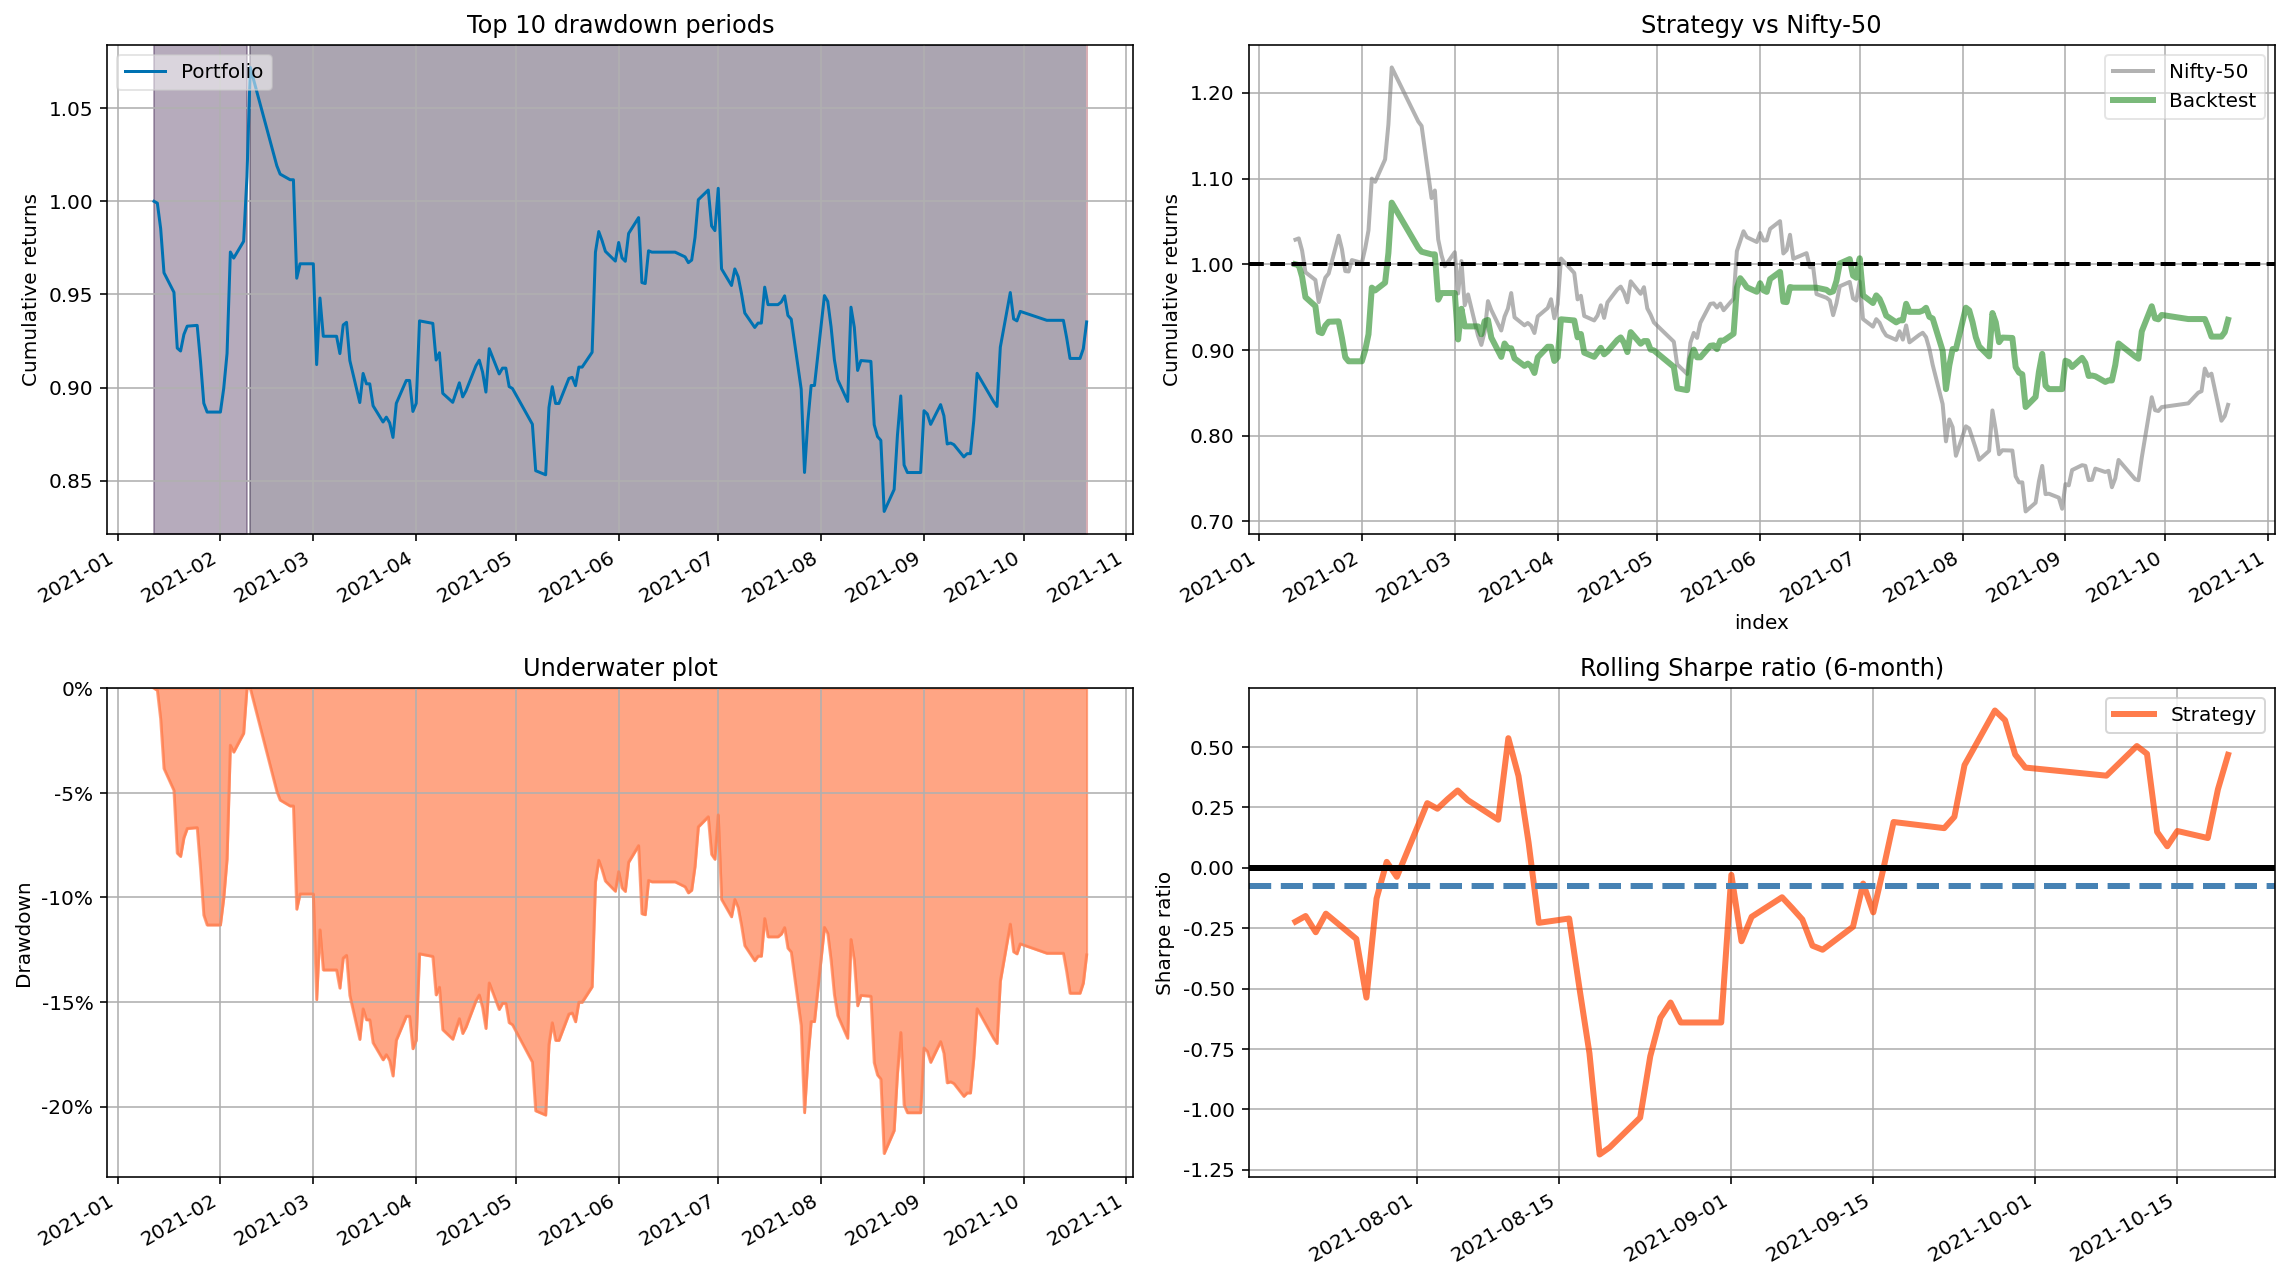

In [41]:
# plot performance for strategy vs benchmark
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 9),constrained_layout=True)
axes = ax.flatten()

pf.plot_drawdown_periods(returns=returns, ax=axes[0])
axes[0].grid(True)
pf.plot_rolling_returns(returns=returns,
                        factor_returns=benchmark_rets,
                        ax=axes[1], title='Strategy vs Nifty-50')
axes[1].grid(True)
pf.plot_drawdown_underwater(returns=returns, ax=axes[2])
axes[2].grid(True)
pf.plot_rolling_sharpe(returns=returns, ax=axes[3])
axes[3].grid(True)
# fig.suptitle('Strategy vs Nifty-50 (Buy and Hold)', fontsize=16, y=0.990)

plt.grid(True)
plt.legend()
plt.tight_layout()
# plt.savefig('images/chart3', dpi=300)
plt.show()

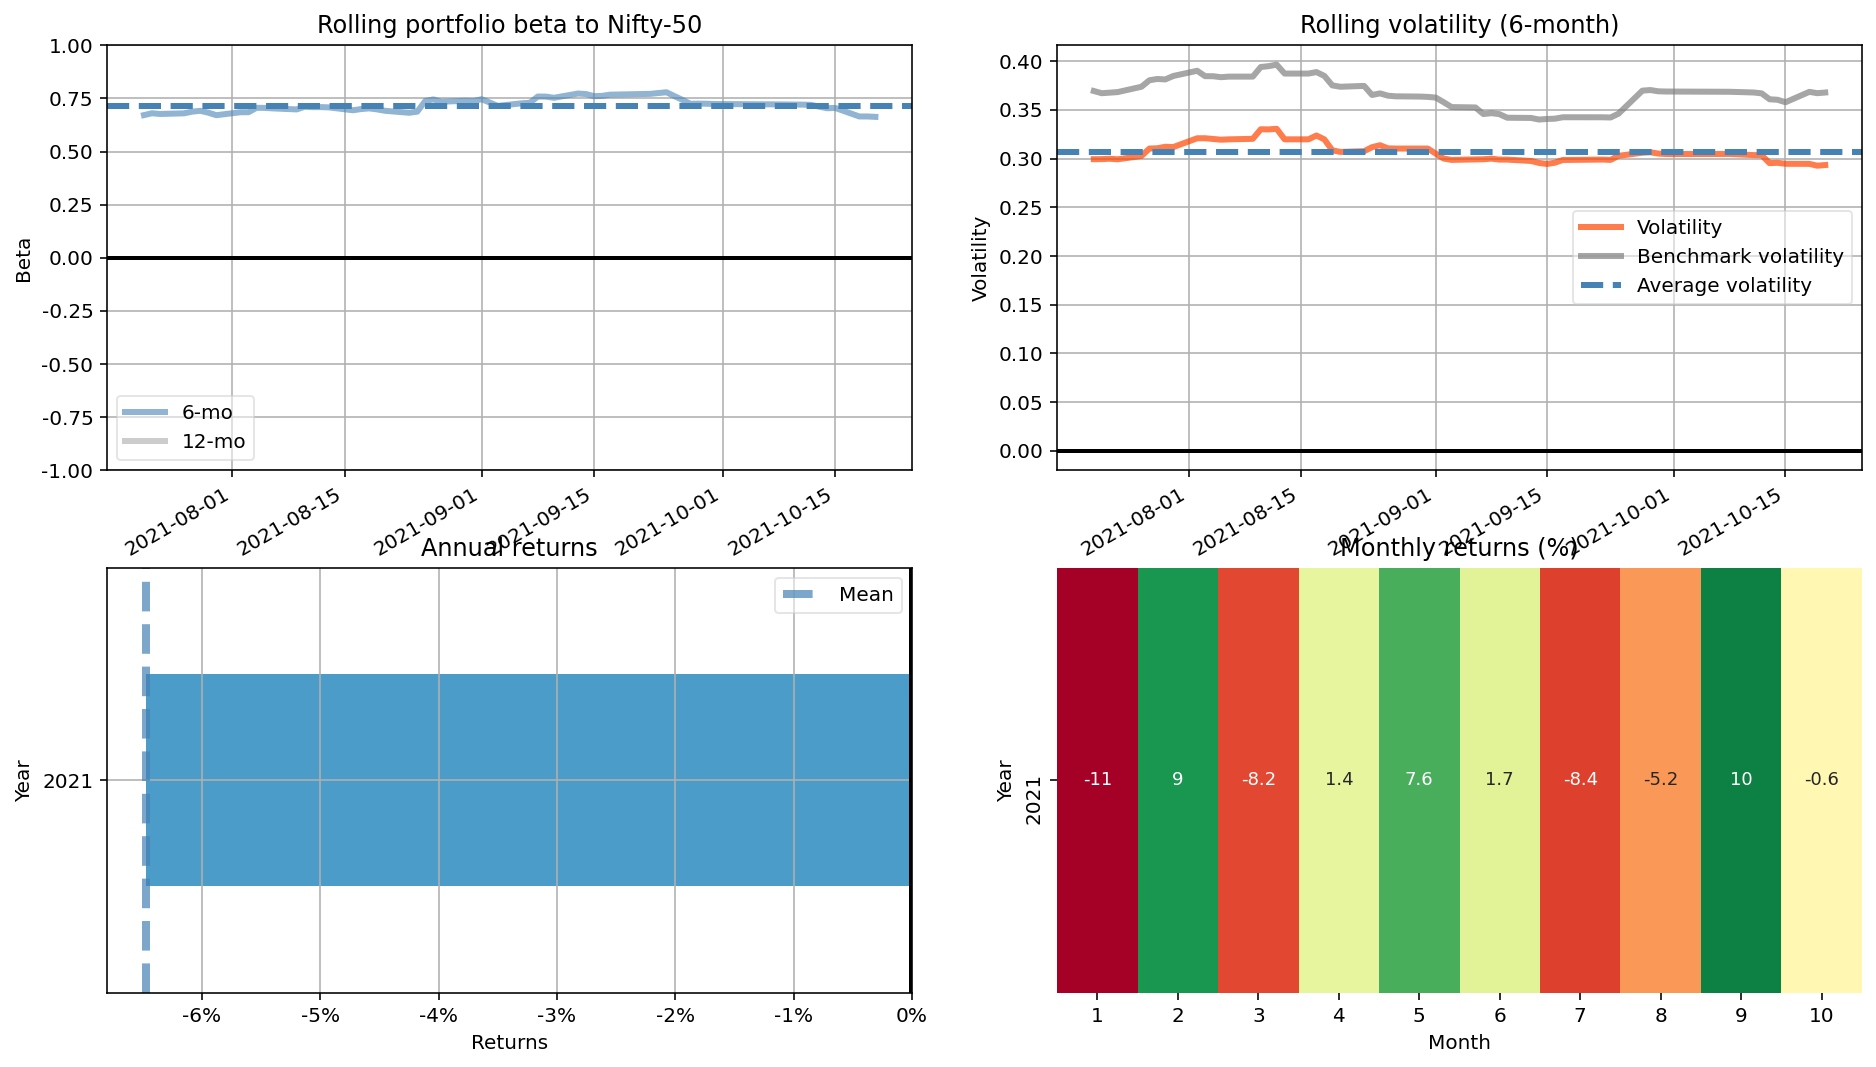

In [42]:
# plot performance for strategy vs benchmark
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 9),constrained_layout=True)
axes = ax.flatten()

pf.plot_rolling_beta(returns=returns, factor_returns=benchmark_rets, ax=axes[0])
axes[0].grid(True)

pf.plot_rolling_volatility(returns=returns, factor_returns=benchmark_rets,ax=axes[1])
axes[1].grid(True)

pf.plot_annual_returns(returns=returns, ax=axes[2])
axes[2].grid(True)

pf.plot_monthly_returns_heatmap(returns=returns, ax=axes[3],)
# fig.suptitle('BL Portfolio vs BSE-SENSEX - 2', fontsize=16, y=1.0)


plt.tight_layout()
# plt.savefig('images/chart4', dpi=300)
plt.show()